In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2 as cv
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from utils import build_model, draw_faces


2022-04-26 16:56:11.165349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/Dev/anaconda3/envs/tf_opencv/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-26 16:56:11.165371: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Dataset

In [160]:
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [163]:
test_ds = tf.keras.utils.image_dataset_from_directory('test',color_mode='grayscale',image_size=(64,64),class_names=emotion_labels)
train_ds = tf.keras.utils.image_dataset_from_directory('train',color_mode='grayscale',image_size=(64,64),class_names=emotion_labels)

Found 7178 files belonging to 7 classes.
Found 28709 files belonging to 7 classes.


In [164]:
def normalize_ds(img,label):
    return img/255.0,label

In [165]:
train_ds = train_ds.map(normalize_ds)
test_ds = test_ds.map(normalize_ds)

# Model

In [2]:
model = tf.keras.models.load_model('fer2013_big_XCEPTION.54-0.66.hdf5')

2022-04-26 16:56:19.876542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 16:56:19.876832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/Dev/anaconda3/envs/tf_opencv/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-26 16:56:19.876895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/Dev/anaconda3/envs/tf_opencv/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-26 16:56:19.876962: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcub

This model is trained on fer2013 but it is bad trained and some of its labels are swaped relatively to the one's I have.

I will train it on fer2013 dataset. 

In [168]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 31, 31, 32)   288         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 31, 31, 32)  128         ['conv2d_1[0][0]']               
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 31, 31, 32)   0           ['block1_conv1_bn[0][0]']  

In [169]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.sparse_categorical_crossentropy, \
     metrics=['accuracy',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name="sparse_top_k_categorical_accuracy", dtype=None)])

# Train

Experiments have shown that data augmentation has poor influence on the overall model.

In [170]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

save_best = tf.keras.callbacks.ModelCheckpoint(
    'fine_tuned_models/bigx_weights_final',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None
)

change_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=4,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)


In [171]:
history = model.fit(train_ds.shuffle(1000),validation_data=test_ds, epochs = 25,callbacks=[early_stopping,save_best,change_lr])

Epoch 1/25


2022-04-25 22:25:14.706417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 71 of 1000
2022-04-25 22:25:24.735055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 151 of 1000
2022-04-25 22:25:34.726154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 229 of 1000
2022-04-25 22:25:44.632434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 311 of 1000
2022-04-25 22:25:54.648636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 391 of 1000
2022-04-25 22:26:04.636250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 473 of 1000
2022-04-25 22:26:14.661371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle bu

898/898 [==============================] - 284s 190ms/step - loss: 1.2911 - accuracy: 0.5804 - sparse_top_k_categorical_accuracy: 0.7636 - val_loss: 1.2208 - val_accuracy: 0.5642 - val_sparse_top_k_categorical_accuracy: 0.7515 - lr: 1.0000e-04
Epoch 2/25
898/898 [==============================] - 175s 194ms/step - loss: 0.8395 - accuracy: 0.6861 - sparse_top_k_categorical_accuracy: 0.8609 - val_loss: 1.1289 - val_accuracy: 0.5984 - val_sparse_top_k_categorical_accuracy: 0.7806 - lr: 1.0000e-04
Epoch 3/25
898/898 [==============================] - 180s 200ms/step - loss: 0.7166 - accuracy: 0.7357 - sparse_top_k_categorical_accuracy: 0.8919 - val_loss: 1.0879 - val_accuracy: 0.6229 - val_sparse_top_k_categorical_accuracy: 0.7969 - lr: 1.0000e-04
Epoch 4/25
898/898 [==============================] - 206s 229ms/step - loss: 0.6349 - accuracy: 0.7700 - sparse_top_k_categorical_accuracy: 0.9101 - val_loss: 1.0912 - val_accuracy: 0.6323 - val_sparse_top_k_categorical_accuracy: 0.8057 - lr: 1.

In [172]:
model.evaluate(test_ds)

225/225 [==============================] - 7s 32ms/step - loss: 1.0871 - accuracy: 0.6432 - sparse_top_k_categorical_accuracy: 0.8125


[1.087103009223938, 0.6432153582572937, 0.8124825954437256]

# Appliance

In [173]:
for img,label in train_ds.take(1):
    pass

In [174]:
prediction = model.predict(img)
label_id = np.argmax(prediction,axis=1)

1/1 [==============================] - 0s 160ms/step


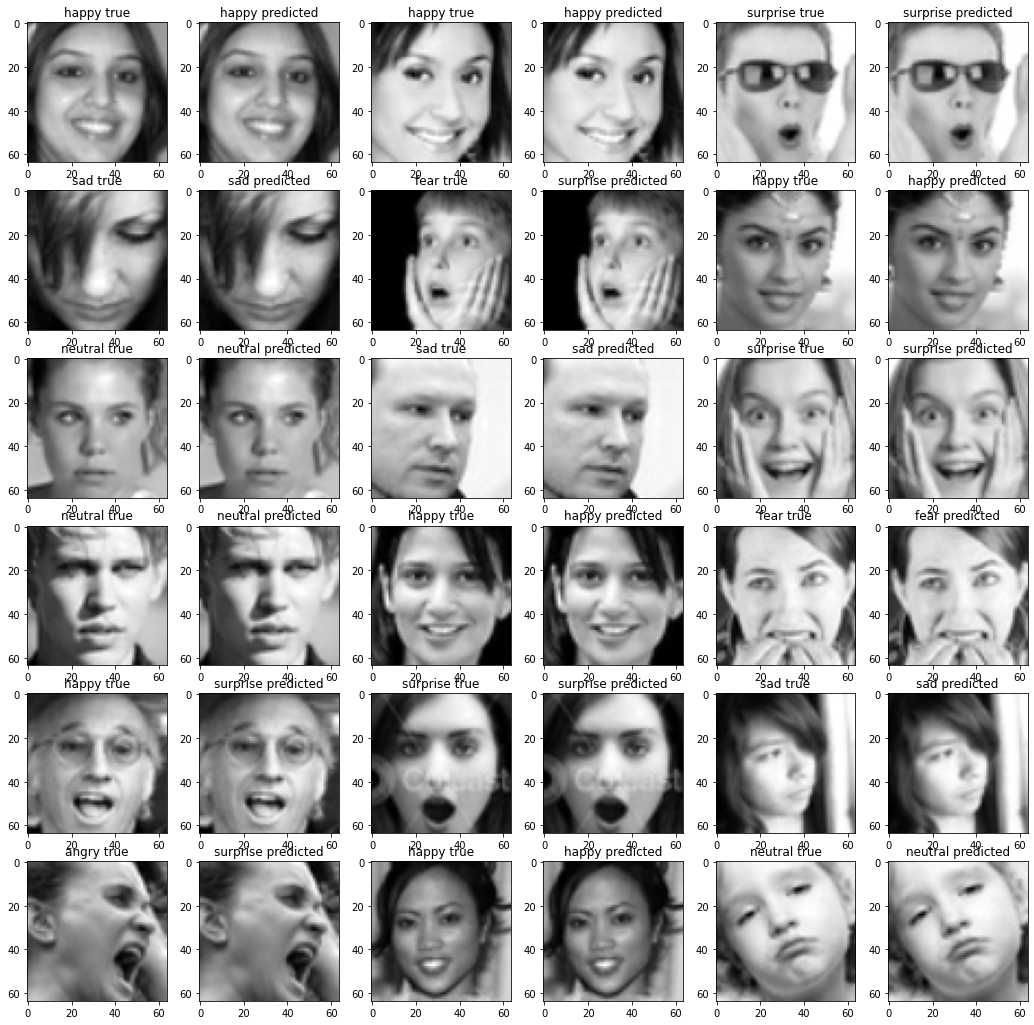

In [178]:
_,ax = plt.subplots(6,6,figsize=(18,18))
im_num = -1
for i in range(6):
    for j in range(6):
        if (i*6 + j) % 2 == 0:
            im_num +=1 
            ax[i][j].set_title(emotion_labels[label[im_num].numpy()] + ' true')
            ax[i][j].imshow(img[im_num],cmap='gray')
        else:
            ax[i][j].set_title(emotion_labels[label_id[im_num]] + ' predicted')
            ax[i][j].imshow(img[im_num],cmap='gray')

In [194]:
def save_prediction(img):
    if isinstance(img,str):
        img = cv.imread(img)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    prediction_img = draw_faces(model, img, 0, 'opencv', (64,64), emotion_labels)
    cv.imwrite('img_pred.jpg',cv.cvtColor(prediction_img,cv.COLOR_BGR2RGB))
    return prediction_img

1/1 [==============================] - 0s 17ms/step


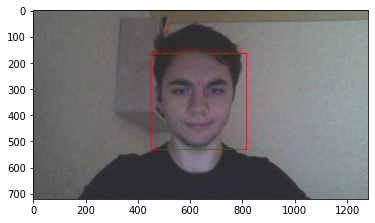

In [196]:
plt.imshow(save_prediction('happy.jpg'))